In [1]:
import sys
sys.path.append('..')
from utils import *
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from tqdm import trange, tqdm

Get a list of all the images in the `base_dir/images` directory. We also make sure each **image** has an associated **annotation**. We then just combine both train and test 

In [7]:
base_dir = '../data/gray_80_80_annotated/'
image_dir = base_dir + 'images/'
anno_dir  = base_dir + 'annotations/'
all_data = get_data_point_names(image_dir, anno_dir, count=None)
print(all_data[0:10])

  1%|          | 113/19796 [00:00<00:17, 1128.20it/s]

Importing images and annotations.


100%|██████████| 19796/19796 [00:17<00:00, 1123.32it/s]

[{'image_name': 'frame17500', 'steering': array(380.)}, {'image_name': 'frame00138', 'steering': array(322.)}, {'image_name': 'frame09879', 'steering': array(3.)}, {'image_name': 'frame04699', 'steering': array(912.)}, {'image_name': 'frame15507', 'steering': array(347.)}, {'image_name': 'frame04534', 'steering': array(772.)}, {'image_name': 'frame05564', 'steering': array(650.)}, {'image_name': 'frame05263', 'steering': array(573.)}, {'image_name': 'frame16813', 'steering': array(144.)}, {'image_name': 'frame14275', 'steering': array(379.)}]



Next, because we want to perform some stats we need to separate the annotations into their own np.array

In [13]:
annos = list()
for ele in all_data:
    annos.append(ele["steering"])

Next we run do some stats to see if we have any biases in the data

mean: 487.3090018185492
median: 449.0
mode: ModeResult(mode=array([1021.]), count=array([1394]))
var: 68200.9063869406
std: 261.1530325057333


[-10, 1024, 0, 200]

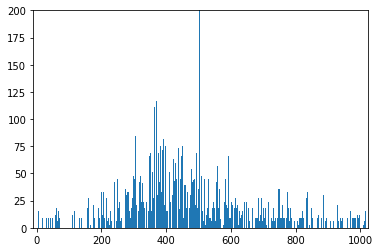

In [14]:
print("mean: {}".format(np.mean(annos)))
print("median: {}".format(np.median(annos)))
print("mode: {}".format(stats.mode(annos)))
print("var: {}".format(np.var(annos)))
print("std: {}".format(np.std(annos)))
plt.hist(annos, 1024)
plt.axis([-10, 1024, 0, 200])

If there is a definate bias in your data then we'll need to even it out. The code below compiles a dictionary with each key being a steering value (eg: 0-1023) and the value being a list of the corriponding image name. We will use this to select up to `max_count` number of images associated with a given value.

```
# eg:
evened_annos = {200: [frame01, frame20, frame04], 
                201: [frame03, frame07]...so on}
```

In [71]:
evened_annos = {}
for ele in all_data:
    name = ele['image_name']
    a    = ele['steering']
    if int(a) not in evened_annos.keys():
        evened_annos[int(a)] = [name,]
    else:
        evened_annos[int(a)].append(name)

Here we only select `max_count` from each `key`

In [72]:
print(evened_annos[400])

['frame04371', 'frame17830', 'frame05167', 'frame10214', 'frame04367', 'frame16111', 'frame17832', 'frame12574', 'frame05168', 'frame17833', 'frame10218', 'frame05169', 'frame04369', 'frame04375', 'frame02210', 'frame02215', 'frame16112', 'frame02209', 'frame04370', 'frame17827', 'frame16114', 'frame04364', 'frame05171', 'frame16107', 'frame02208', 'frame02214', 'frame12573', 'frame02213', 'frame04368', 'frame02207', 'frame10216', 'frame17831', 'frame16113', 'frame12575', 'frame17834', 'frame10215', 'frame16106', 'frame17829', 'frame12576', 'frame04374', 'frame16109', 'frame04373', 'frame12572', 'frame02212', 'frame05170', 'frame16110', 'frame04372', 'frame16108', 'frame05172', 'frame17828', 'frame10213', 'frame12577', 'frame17835', 'frame04366', 'frame10217', 'frame04365', 'frame02211']


In [73]:
max_count = 20
for key in evened_annos.keys():
    np.random.shuffle(evened_annos[key])
    if len(evened_annos[key]) > max_count:
        evened_annos[key] = evened_annos[key][:max_count]

Now we re-run our stats

In [75]:
steer = []
images = []
for key in evened_annos.keys():
    for im in evened_annos[key]:
        steer.append(key)
        images.append(im)

count: 10170
mean: 500.39567354965584
median: 478.0
mode: ModeResult(mode=array([3]), count=array([20]))
var: 57039.67530084919
std: 238.82980404641543


[-10, 1024, 0, 60]

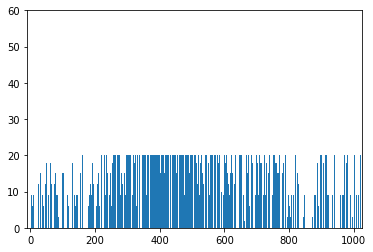

In [76]:
test = np.asarray(steer)
print("count: {}".format(len(test)))
print("mean: {}".format(np.mean(test)))
print("median: {}".format(np.median(test)))
print("mode: {}".format(stats.mode(test)))
print("var: {}".format(np.var(test)))
print("std: {}".format(np.std(test)))
plt.hist(test, 1024)
plt.axis([-10, 1024, 0, 60])

Finally we split into training and test sets then write to file

In [80]:
import os

training_frac = 0.8
rand_idxs = np.array(list(range(len(images))))
np.random.shuffle(rand_idxs)
train_path = "../data/evened_train.txt"
test_path = "../data/evened_test.txt"
for idx in rand_idxs:
    path = train_path
    if np.random.rand() > training_frac:
        path = test_path
    n = images[idx]
    s = steer[idx]
    with open(path, 'a') as file:
        file.write("{}, {}\n".format(n,s))